<a href="https://colab.research.google.com/github/Zhang1in/Data-Science--Cheat-Sheet/blob/master/%E2%80%9CCells_Retina_Net_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
!wget https://ma-competitions-bj4.obs.cn-north-4.myhuaweicloud.com/SODIC/garbage/datasets/trainval.zip
!unzip /content/trainval.zip
%cd /content/trainval
!pip install labelme

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: trainval/VOC2007/JPEGImages/img_3934.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3936.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3937.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3938.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3939.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3940.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3943.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3945.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3946.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3947.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3949.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3951.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3956.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_396.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3960.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3961.jpg  
  inflating: trainval/VOC2007/JPEGImages/img_3962.jpg  
  inflating: trainval/

# Annotation

In [5]:
# -*- coding:utf-8 -*-
# !/usr/bin/env python
 
import argparse
import json
import matplotlib.pyplot as plt
import skimage.io as io
import cv2
from labelme import utils
import numpy as np
import glob
import PIL.Image
import os,sys
import pdb
 
class PascalVOC2coco(object):
    def __init__(self, xml=[], save_json_path='./new.json'):
        '''
        :param xml: 所有Pascal VOC的xml文件路径组成的列表
        :param save_json_path: json保存位置
        '''
        self.xml = xml
        self.save_json_path = save_json_path
        self.images = []
        self.categories = []
        self.annotations = []
        # self.data_coco = {}
        self.label = []
        self.annID = 1
        self.height = 0
        self.width = 0
        self.ob = []
 
        self.save_json()
 
    def data_transfer(self):
        for num, json_file in enumerate(self.xml):
 
            # 进度输出
            sys.stdout.write('\r>> Converting image %d/%d' % (
                num + 1, len(self.xml)))
            sys.stdout.flush()

            
            
 

            self.json_file = json_file
            # print("self.json", self.json_file)
            self.num = num 
            # print(self.num)
            path = os.path.dirname(self.json_file)
            # print(path)
            path = os.path.dirname(path)
            # print(path)
            path=os.path.split(self.json_file)[0]
            path=os.path.split(path)[0]
            obj_path = glob.glob(os.path.join(path, 'SegmentationObject', '*.png'))
            #print(obj_path)
            with open(json_file, 'r') as fp:
                #print(fp)
                flag = 0
                for p in fp:
                    #print(p)
                    # if 'folder' in p:
                    #     folder =p.split('>')[1].split('<')[0]
                    f_name = 1
                    if 'filename' in p:
                        self.filen_ame = os.path.split(self.json_file)[-1][:-4]+'.jpg'
                        # p.split('>')[1].split('<')[0]
                        #print(self.filen_ame)
                        f_name = 0
 
                        self.path = os.path.join(path, 'SegmentationObject', self.filen_ame.split('.')[0] + '.png')
                        #if self.path not in obj_path:
                        #    break
 
 
                    if 'width' in p:
                        self.width = int(p.split('>')[1].split('<')[0])
                        #print(self.width)
                    if 'height' in p:
                        self.height = int(p.split('>')[1].split('<')[0])
 
                        self.images.append(self.image())
                        #print(self.image())
 
                    if flag == 1:
                        self.supercategory = self.ob[0]
                        if self.supercategory not in self.label:
                            self.categories.append(self.categorie())
                            self.label.append(self.supercategory)
 
                        # 边界框
                        x1 = int(self.ob[1]);
                        y1 = int(self.ob[2]);
                        x2 = int(self.ob[3]);
                        y2 = int(self.ob[4])
                        self.rectangle = [x1, y1, x2, y2]
                        self.bbox = [x1, y1, x2 - x1, y2 - y1]  # COCO 对应格式[x,y,w,h]
 
                        self.annotations.append(self.annotation())
                        self.annID += 1
                        self.ob = []
                        flag = 0
                    elif f_name == 1:
                        if 'name' in p:
                            self.ob.append(p.split('>')[1].split('<')[0])
 
                        if 'xmin' in p:
                            self.ob.append(p.split('>')[1].split('<')[0])
 
                        if 'ymin' in p:
                            self.ob.append(p.split('>')[1].split('<')[0])
 
                        if 'xmax' in p:
                            self.ob.append(p.split('>')[1].split('<')[0])
 
                        if 'ymax' in p:
                            self.ob.append(p.split('>')[1].split('<')[0])
                            flag = 1
 
                    '''
                    if '<object>' in p:
                        # 类别
                        print(next(fp))
                        d = [next(fp).split('>')[1].split('<')[0] for _ in range(7)]
                        self.supercategory = d[0]
                        if self.supercategory not in self.label:
                            self.categories.append(self.categorie())
                            self.label.append(self.supercategory)
                        # 边界框
                        x1 = int(d[-4]);
                        y1 = int(d[-3]);
                        x2 = int(d[-2]);
                        y2 = int(d[-1])
                        self.rectangle = [x1, y1, x2, y2]
                        self.bbox = [x1, y1, x2 - x1, y2 - y1]  # COCO 对应格式[x,y,w,h]
                        self.annotations.append(self.annotation())
                        self.annID += 1
                     '''
 
        sys.stdout.write('\n')
        sys.stdout.flush()
 
    def image(self):
        image = {}
        image['height'] = self.height
        image['width'] = self.width
        image['id'] = self.num + 1
        image['file_name'] = self.filen_ame
        return image
 
    def categorie(self):
        categorie = {}
        categorie['supercategory'] = self.supercategory
        categorie['id'] = len(self.label) + 1  # 0 默认为背景
        categorie['name'] = self.supercategory
        return categorie
 
    def annotation(self):
        annotation = {}
        # annotation['segmentation'] = [self.getsegmentation()]
        annotation['segmentation'] = [list(map(float, self.getsegmentation()))]
        annotation['iscrowd'] = 0
        annotation['image_id'] = self.num + 1
        # annotation['bbox'] = list(map(float, self.bbox))
        annotation['bbox'] = self.bbox
        annotation['category_id'] = self.getcatid(self.supercategory)
        annotation['id'] = self.annID
        return annotation
 
    def getcatid(self, label):
        for categorie in self.categories:
            if label == categorie['name']:
                return categorie['id']
        return -1
 
    def getsegmentation(self):
 
        try:
            mask_1 = cv2.imread(self.path, 0)
            mask = np.zeros_like(mask_1, np.uint8)
            rectangle = self.rectangle
            mask[rectangle[1]:rectangle[3], rectangle[0]:rectangle[2]] = mask_1[rectangle[1]:rectangle[3],
                                                                         rectangle[0]:rectangle[2]]
 
            # 计算矩形中点像素值
            mean_x = (rectangle[0] + rectangle[2]) // 2
            mean_y = (rectangle[1] + rectangle[3]) // 2
 
            end = min((mask.shape[1], int(rectangle[2]) + 1))
            start = max((0, int(rectangle[0]) - 1))
 
            flag = True
            for i in range(mean_x, end):
                x_ = i;
                y_ = mean_y
                pixels = mask_1[y_, x_]
                if pixels != 0 and pixels != 220:  # 0 对应背景 220对应边界线
                    mask = (mask == pixels).astype(np.uint8)
                    flag = False
                    break
            if flag:
                for i in range(mean_x, start, -1):
                    x_ = i;
                    y_ = mean_y
                    pixels = mask_1[y_, x_]
                    if pixels != 0 and pixels != 220:
                        mask = (mask == pixels).astype(np.uint8)
                        break
            self.mask = mask
 
            return self.mask2polygons()
 
        except:
            return [0]
 
    def mask2polygons(self):
        contours = cv2.findContours(self.mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # 找到轮廓线
        bbox=[]
        for cont in contours[1]:
            [bbox.append(i) for i in list(cont.flatten())]
            # map(bbox.append,list(cont.flatten()))
        return bbox # list(contours[1][0].flatten())
 
    # '''
    def getbbox(self, points):
        # img = np.zeros([self.height,self.width],np.uint8)
        # cv2.polylines(img, [np.asarray(points)], True, 1, lineType=cv2.LINE_AA)  # 画边界线
        # cv2.fillPoly(img, [np.asarray(points)], 1)  # 画多边形 内部像素值为1
        polygons = points
        mask = self.polygons_to_mask([self.height, self.width], polygons)
        return self.mask2box(mask)
 
    def mask2box(self, mask):
        '''从mask反算出其边框
        mask：[h,w]  0、1组成的图片
        1对应对象，只需计算1对应的行列号（左上角行列号，右下角行列号，就可以算出其边框）
        '''
        # np.where(mask==1)
        index = np.argwhere(mask == 1)
        rows = index[:, 0]
        clos = index[:, 1]
        # 解析左上角行列号
        left_top_r = np.min(rows)  # y
        left_top_c = np.min(clos)  # x
 
        # 解析右下角行列号
        right_bottom_r = np.max(rows)
        right_bottom_c = np.max(clos)
 
        # return [(left_top_r,left_top_c),(right_bottom_r,right_bottom_c)]
        # return [(left_top_c, left_top_r), (right_bottom_c, right_bottom_r)]
        # return [left_top_c, left_top_r, right_bottom_c, right_bottom_r]  # [x1,y1,x2,y2]
        return [left_top_c, left_top_r, right_bottom_c - left_top_c,
                right_bottom_r - left_top_r]  # [x1,y1,w,h] 对应COCO的bbox格式
 
    def polygons_to_mask(self, img_shape, polygons):
        mask = np.zeros(img_shape, dtype=np.uint8)
        mask = PIL.Image.fromarray(mask)
        xy = list(map(tuple, polygons))
        PIL.ImageDraw.Draw(mask).polygon(xy=xy, outline=1, fill=1)
        mask = np.array(mask, dtype=bool)
        return mask
 
    # '''
    def data2coco(self):
        data_coco = {}
        data_coco['images'] = self.images
        data_coco['categories'] = self.categories
        data_coco['annotations'] = self.annotations
        return data_coco
 
    def save_json(self):
        self.data_transfer()
        self.data_coco = self.data2coco()
        # 保存json文件
        json.dump(self.data_coco, open(self.save_json_path, 'w'), indent=4)  # indent=4 更加美观显示
 
 
xml_file = glob.glob('/content/trainval/VOC2007/Annotations/*.xml')
# xml_file=['./Annotations/000032.xml']
#xml_file=['00000007_05499_d_0000037.xml']
PascalVOC2coco(xml_file, 'train.json')

>> Converting image 14964/14964


# Data

In [6]:
!git clone https://github.com/ChristianMarzahl/ObjectDetection.git

Cloning into 'ObjectDetection'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 215 (delta 8), reused 18 (delta 7), pack-reused 190
Receiving objects: 100% (215/215), 65.07 MiB | 10.94 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [7]:
%cd /content/trainval/ObjectDetection

/content/trainval/ObjectDetection


In [0]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [0]:
dots = Path('/content/trainval/VOC2007/JPEGImages')

In [10]:
dots

PosixPath('/content/trainval/VOC2007/JPEGImages')

In [0]:
images, lbl_bbox = get_annotations('/content/trainval/train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

### Size
- 256
- 512 
- 1024


In [0]:
size = 256
bs = 16

In [0]:
data = (ObjectItemList.from_folder(dots)
        #Where are the images? -> in coco
        .random_split_by_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=bs, collate_fn=bb_pad_collate))
        #Finally we convert to a DataBunch and we use bb_pad_collate
data = data.normalize(imagenet_stats)

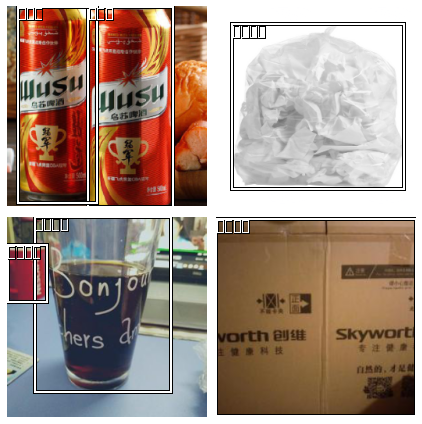

In [15]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(6,6))

### Create anchors and test them 

In [0]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])

In [17]:
len(anchors)

24480

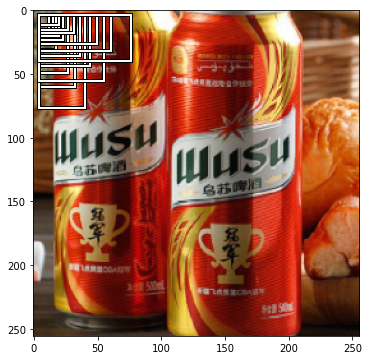

In [18]:
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(image2np(data.valid_ds[0][0].data))
for i, bbox in enumerate(anchors[:18]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

## The objects on the left side are covered by anchors. On the right side ware objects that would be missed in training

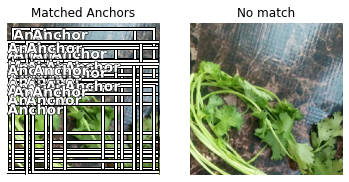

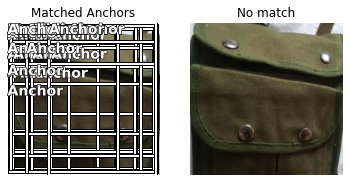

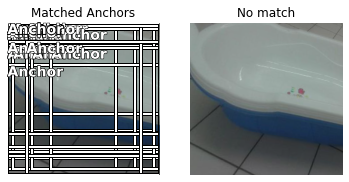

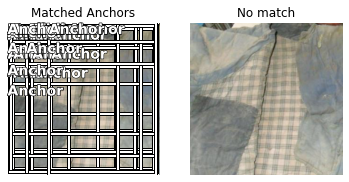

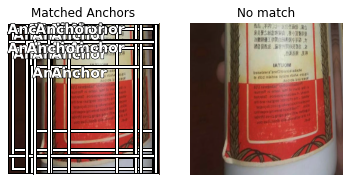

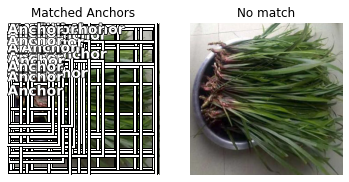

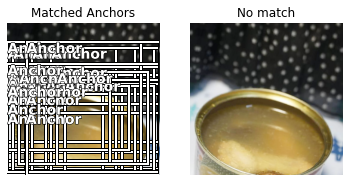

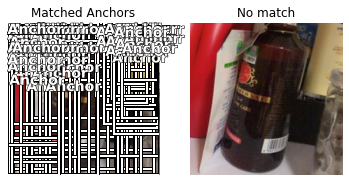

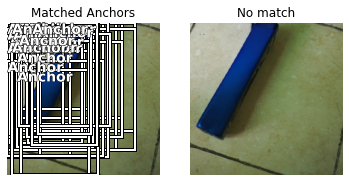

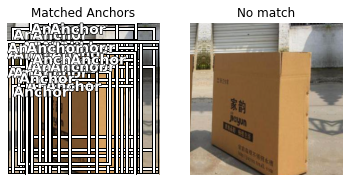

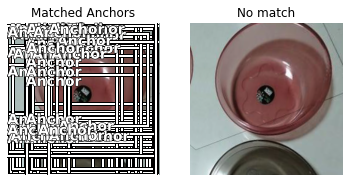

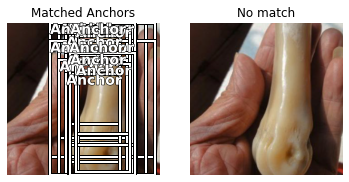

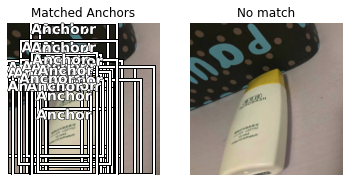

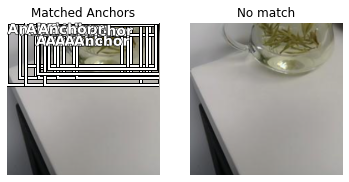

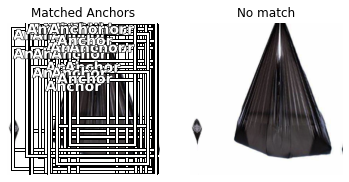

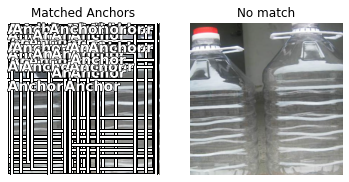

In [19]:
all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(6,6))

## Model and Loss 

In [20]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)
#model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])

In [0]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-一次性快餐盒,AP-书籍纸张,AP-充电宝,AP-剩饭剩菜,AP-包,AP-垃圾桶,AP-塑料器皿,AP-塑料玩具,AP-塑料衣架,AP-大骨头,AP-干电池,AP-快递纸袋,AP-插头电线,AP-旧衣服,AP-易拉罐,AP-枕头,AP-果皮果肉,AP-毛绒玩具,AP-污损塑料,AP-污损用纸,AP-洗护用品,AP-烟蒂,AP-牙签,AP-玻璃器皿,AP-砧板,AP-筷子,AP-纸盒纸箱,AP-花盆,AP-茶叶渣,AP-菜帮菜叶,AP-蛋壳,AP-调料瓶,AP-软膏,AP-过期药物,AP-酒瓶,AP-金属厨具,AP-金属器皿,AP-金属食品罐,AP-锅,AP-陶瓷器皿,AP-鞋,AP-食用油桶,AP-饮料瓶,AP-鱼骨,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


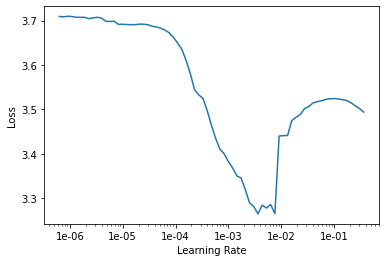

In [23]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.save('1st')

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-一次性快餐盒,AP-书籍纸张,AP-充电宝,AP-剩饭剩菜,AP-包,AP-垃圾桶,AP-塑料器皿,AP-塑料玩具,AP-塑料衣架,AP-大骨头,AP-干电池,AP-快递纸袋,AP-插头电线,AP-旧衣服,AP-易拉罐,AP-枕头,AP-果皮果肉,AP-毛绒玩具,AP-污损塑料,AP-污损用纸,AP-洗护用品,AP-烟蒂,AP-牙签,AP-玻璃器皿,AP-砧板,AP-筷子,AP-纸盒纸箱,AP-花盆,AP-茶叶渣,AP-菜帮菜叶,AP-蛋壳,AP-调料瓶,AP-软膏,AP-过期药物,AP-酒瓶,AP-金属厨具,AP-金属器皿,AP-金属食品罐,AP-锅,AP-陶瓷器皿,AP-鞋,AP-食用油桶,AP-饮料瓶,AP-鱼骨,time
0,1.282311,1.255510,0.042015,0.213955,1.041554,0.000000,0.000000,0.022475,0.056270,0.189596,0.000000,0.140307,0.003125,0.000000,0.000000,0.000000,0.000000,0.003916,0.000000,0.002177,0.011029,0.129272,0.341670,0.000000,0.000000,0.002096,0.000000,0.000000,0.024272,0.000000,0.000000,0.000000,0.000000,0.362758,0.005102,0.000000,0.000000,0.072852,0.123044,0.034775,0.000000,0.000000,0.000000,0.000000,0.072328,0.000000,0.248182,0.000000,0.003401,06:30
1,0.982675,0.927050,0.141216,0.162465,0.764585,0.110455,0.000000,0.127808,0.001272,0.142269,0.000000,0.293919,0.287026,0.392717,0.000000,0.006279,0.138763,0.064644,0.298031,0.032992,0.071433,0.269594,0.411460,0.159588,0.000000,0.134822,0.262085,0.000000,0.098610,0.239957,0.122903,0.000000,0.000000,0.618603,0.564153,0.016129,0.043083,0.252304,0.204951,0.052885,0.000000,0.000000,0.001623,0.108714,0.124876,0.158612,0.327946,0.000000,0.073010,06:28
2,0.780358,0.765643,0.216070,0.140600,0.625042,0.127529,0.000000,0.241709,0.049239,0.431800,0.000000,0.300576,0.331270,0.467018,0.014286,0.159667,0.144321,0.112173,0.432146,0.080492,0.233088,0.352702,0.599135,0.215467,0.000000,0.201875,0.262704,0.096774,0.096211,0.415826,0.159567,0.166173,0.000000,0.808610,0.533803,0.184670,0.070180,0.295588,0.250140,0.155972,0.000000,0.000000,0.076712,0.201929,0.131811,0.445255,0.468131,0.040404,0.152132,06:32


Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 69/69 [00:00<00:00, 279350.36it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 102/102 [00:00<00:00, 6541.78it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 57/57 [00:00<00:00, 209347.92it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 70/70 [00:00<00:00, 107036.56it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 91/91 [00:00<00:00, 201308.89it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 259/259 [00:00<00:00, 45561.58it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 150/150 [00:00<00:00, 22328.34it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 240/240 [00:00<00:00, 454872.55it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 68/68 [00:00<00:00, 240078.01it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 206/206 [00:00<00:00, 142956.09it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 94/94 [00:00<00:00, 199123.52it/s]
Detections: 0it [00:00, ?it/s]
GT: 10

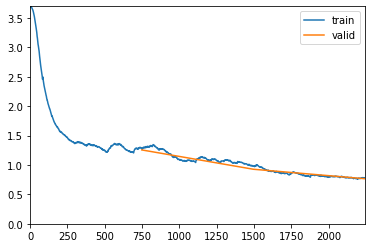

GT: 100%|██████████| 69/69 [00:00<00:00, 59231.88it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 102/102 [00:00<00:00, 36597.01it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 240/240 [00:00<00:00, 41274.06it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 111/111 [00:00<00:00, 295223.68it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 52/52 [00:00<00:00, 90800.92it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 66/66 [00:00<00:00, 56587.09it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 69/69 [00:00<00:00, 46054.58it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 102/102 [00:00<00:00, 18788.71it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 240/240 [00:00<00:00, 14047.94it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 111/111 [00:00<00:00, 15286.07it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 52/52 [00:00<00:00, 44969.86it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 66/66 [00:00<00:00, 

In [25]:
learn.fit_one_cycle(3, 9e-4)

In [0]:
learn.save('2nd')
learn.unfreeze()

In [0]:
learn.load('2nd')

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-一次性快餐盒,AP-书籍纸张,AP-充电宝,AP-剩饭剩菜,AP-包,AP-垃圾桶,AP-塑料器皿,AP-塑料玩具,AP-塑料衣架,AP-大骨头,AP-干电池,AP-快递纸袋,AP-插头电线,AP-旧衣服,AP-易拉罐,AP-枕头,AP-果皮果肉,AP-毛绒玩具,AP-污损塑料,AP-污损用纸,AP-洗护用品,AP-烟蒂,AP-牙签,AP-玻璃器皿,AP-砧板,AP-筷子,AP-纸盒纸箱,AP-花盆,AP-茶叶渣,AP-菜帮菜叶,AP-蛋壳,AP-调料瓶,AP-软膏,AP-过期药物,AP-酒瓶,AP-金属厨具,AP-金属器皿,AP-金属食品罐,AP-锅,AP-陶瓷器皿,AP-鞋,AP-食用油桶,AP-饮料瓶,AP-鱼骨,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


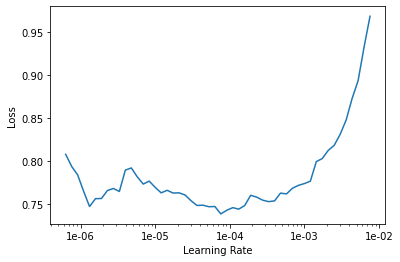

In [35]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-一次性快餐盒,AP-书籍纸张,AP-充电宝,AP-剩饭剩菜,AP-包,AP-垃圾桶,AP-塑料器皿,AP-塑料玩具,AP-塑料衣架,AP-大骨头,AP-干电池,AP-快递纸袋,AP-插头电线,AP-旧衣服,AP-易拉罐,AP-枕头,AP-果皮果肉,AP-毛绒玩具,AP-污损塑料,AP-污损用纸,AP-洗护用品,AP-烟蒂,AP-牙签,AP-玻璃器皿,AP-砧板,AP-筷子,AP-纸盒纸箱,AP-花盆,AP-茶叶渣,AP-菜帮菜叶,AP-蛋壳,AP-调料瓶,AP-软膏,AP-过期药物,AP-酒瓶,AP-金属厨具,AP-金属器皿,AP-金属食品罐,AP-锅,AP-陶瓷器皿,AP-鞋,AP-食用油桶,AP-饮料瓶,AP-鱼骨,time
0,0.642226,0.708175,0.273877,0.128463,0.579711,0.184745,0.000000,0.276770,0.043769,0.418593,0.000000,0.474078,0.337515,0.539079,0.225687,0.255695,0.416833,0.105589,0.518434,0.151970,0.445978,0.447775,0.574843,0.207959,0.000000,0.206929,0.384968,0.031250,0.141587,0.568723,0.198142,0.396137,0.000000,0.768425,0.524715,0.306408,0.128427,0.398763,0.326405,0.176982,0.000000,0.000000,0.103170,0.314713,0.084111,0.503127,0.571146,0.036036,0.255129,06:27
1,0.760981,0.836259,0.230386,0.153719,0.682540,0.057971,0.000000,0.156941,0.090824,0.313992,0.000000,0.533416,0.210766,0.463609,0.100850,0.210523,0.215728,0.100954,0.465041,0.208194,0.276347,0.248418,0.150833,0.255919,0.000000,0.266761,0.385718,0.057664,0.094005,0.435936,0.158163,0.352411,0.000000,0.814091,0.564206,0.431831,0.062104,0.308453,0.293409,0.257199,0.000000,0.000000,0.128815,0.325643,0.023300,0.363078,0.480184,0.013514,0.260152,06:19
2,0.854131,0.873369,0.196732,0.147590,0.725779,0.079529,0.000000,0.050000,0.076197,0.256930,0.000000,0.449172,0.301415,0.412390,0.110010,0.237869,0.257921,0.091445,0.132022,0.130540,0.109587,0.197941,0.348079,0.141570,0.000000,0.199392,0.245984,0.059920,0.027172,0.401659,0.151445,0.373203,0.000000,0.813840,0.464456,0.257847,0.017375,0.249620,0.268900,0.183463,0.000000,0.000000,0.017045,0.308973,0.039434,0.533934,0.452372,0.076952,0.130619,06:22


GT: 100%|██████████| 102/102 [00:00<00:00, 30556.32it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 111/111 [00:00<00:00, 24242.01it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 52/52 [00:00<00:00, 25686.47it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 66/66 [00:00<00:00, 138689.41it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 98/98 [00:00<00:00, 25110.99it/s]


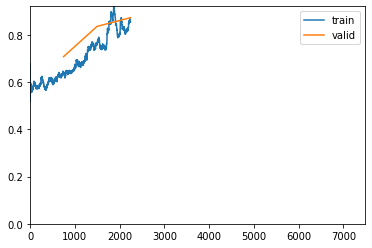

GT: 100%|██████████| 69/69 [00:00<00:00, 119490.91it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 102/102 [00:00<00:00, 61966.83it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 52/52 [00:00<00:00, 28607.53it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 66/66 [00:00<00:00, 301880.11it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 69/69 [00:00<00:00, 60735.99it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 102/102 [00:00<00:00, 26256.23it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 111/111 [00:00<00:00, 20287.94it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 52/52 [00:00<00:00, 31139.89it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 66/66 [00:00<00:00, 243683.15it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 98/98 [00:00<00:00, 74666.99it/s]


KeyboardInterrupt: ignored

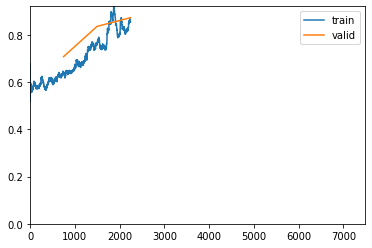

In [29]:
learn.fit_one_cycle(10, 1e-4)

In [0]:
data.train_ds.classes

['background', '0', '1', '2', '3', '4']

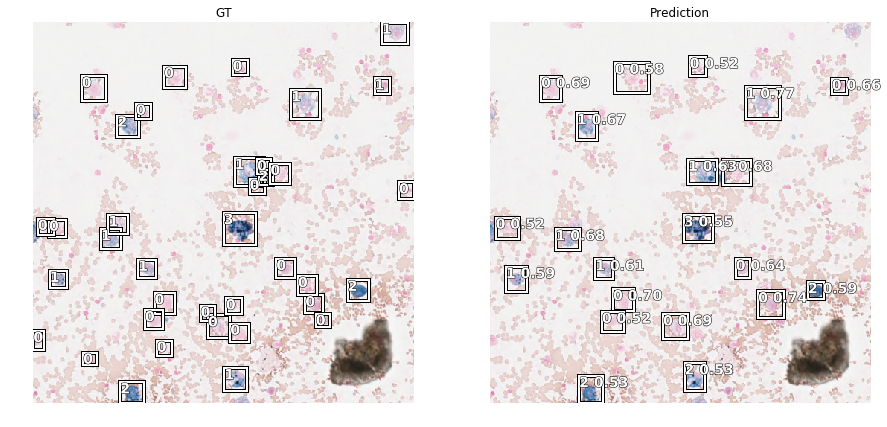

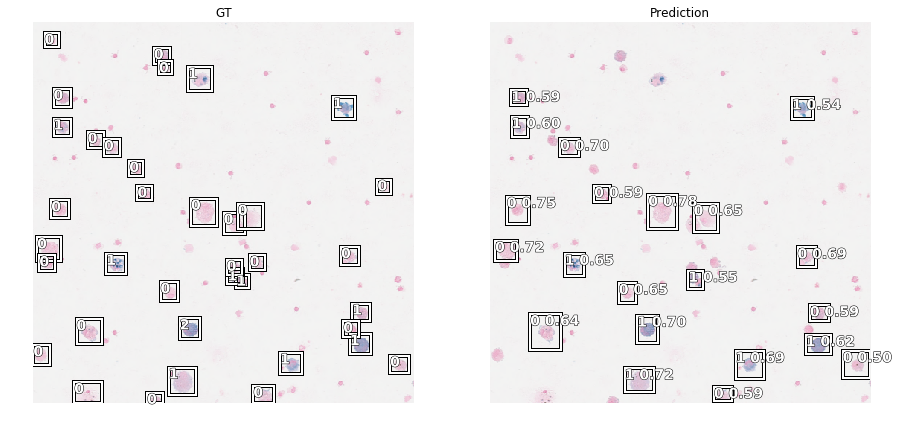

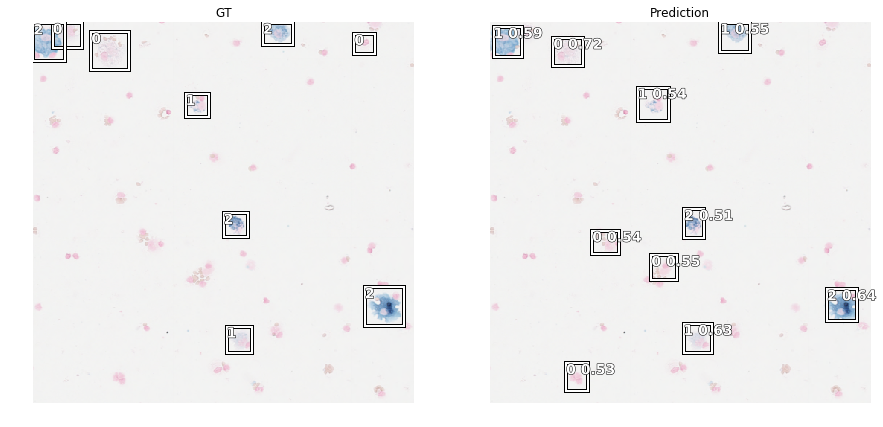

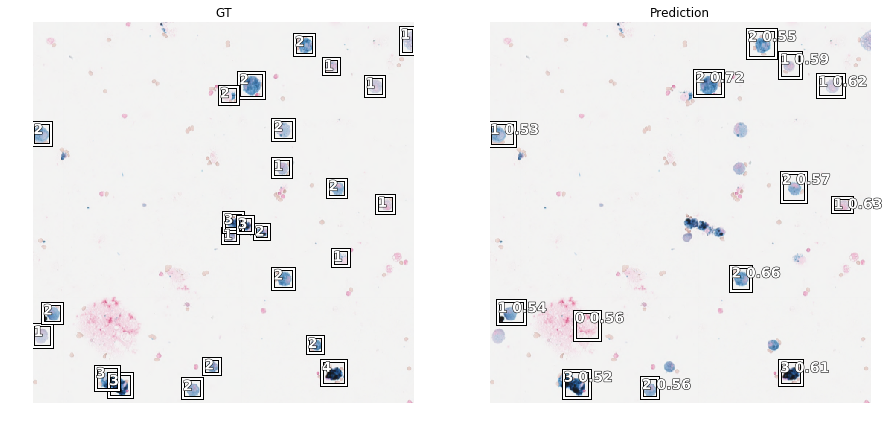

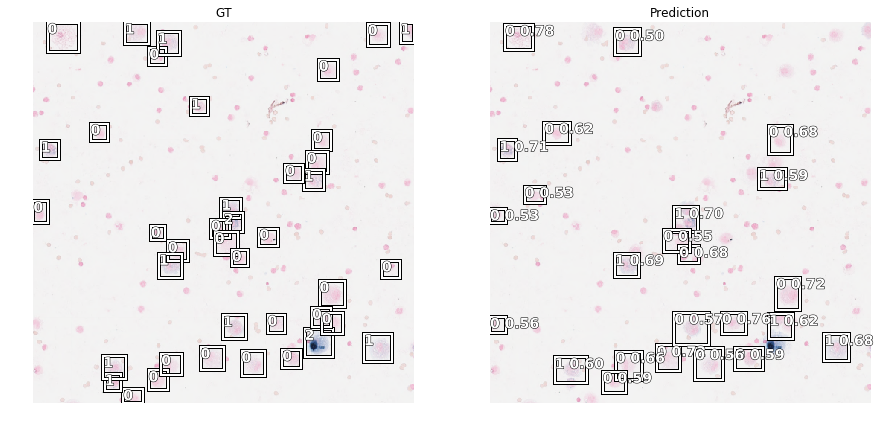

In [0]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=5)